In [1]:
import matplotlib.pyplot as plt
import tqdm
from skimage.feature import hog
from skimage import data, exposure
from FDDB_dataloader import FDDB
import PIL.Image as Image
import torchvision.transforms as T
import numpy as np
import torch
import Model_zoo as Model
import pickle # can not dump lambda function
import dill

## Load HOG features:

In [12]:
train_set = torch.load('HOG_train.pt')
val_set = torch.load('HOG_val.pt')
X_train = train_set['hog_feature']
y_train = train_set['label']
X_val = val_set['hog_feature']
y_val = val_set['label']

## Logistic Regression:

### SGD approach

In [31]:
M = Model.logisticRegression(900,1.)

params = {
    'rounds':1000,
    'optimizer':'SGD', 
    'l2_ratio': 0.1, # 0.0
    'decay':0.99,
    'batchsize':32,
}

M.fit(X_train,y_train, params)

Logistic SGD (acc=0.9855): 100%|██████████| 1000/1000 [20:07<00:00,  1.09it/s]


In [54]:
M.get_acc(X_val, y_val)

0.964443590236402

#### Save Model:

In [35]:
with open('./Model_checkpoints/Logstics_SGD.pkl','wb') as fh:
    dill.dump(M, fh)

#### Load pretrained model

In [57]:
with open('./Model_checkpoints/Logstics_SGD.pkl','rb') as fh:
    M = dill.load(fh)

In [58]:
M.get_acc(X_val, y_val)

0.964443590236402

In [53]:
probs_SGD = M.get_score(X_val)

### Langevin Dynamics Approach

In [3]:
M = Model.logisticRegression(900,1.)

params = {
    'rounds':1000,
    'optimizer':'SLGD', 
    'decay':0.99,
    'batchsize':32,
}

M.fit(X_train,y_train, params)

Logistic SLGD (acc=0.9696): 100%|██████████| 1000/1000 [31:39<00:00,  2.06s/it]


In [4]:
M.get_acc(X_val, y_val)

0.9637144390767579

#### Save Model:

In [5]:
with open('./Model_checkpoints/Logstics_SLGD.pkl','wb') as fh:
    dill.dump(M, fh)

#### Load Pretrained Model

In [59]:
with open('./Model_checkpoints/Logstics_SLGD.pkl','rb') as fh:
    M = dill.load(fh)

In [60]:
M.get_acc(X_val, y_val)

0.9592542763790121

In [61]:
probs_LD = M.get_score(X_val)

### Model Analysis

In [62]:
conf_SGD = np.abs(probs_SGD-0.5)/0.5
conf_LD = np.abs(probs_LD-0.5)/0.5

Text(0.5, 0, 'Classification Confidence')

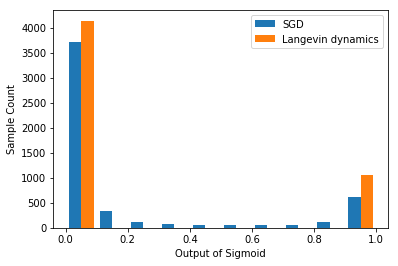

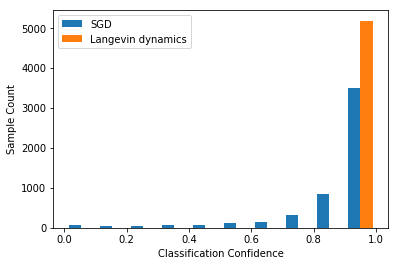

In [63]:
plt.figure()
plt.hist([probs_SGD,probs_LD], label=['SGD','Langevin dynamics'])
plt.legend()
plt.ylabel('Sample Count')
plt.xlabel('Output of Sigmoid')
plt.figure()
plt.hist([conf_SGD,conf_LD], label=['SGD','Langevin dynamics'])
plt.legend()
plt.ylabel('Sample Count')
plt.xlabel('Classification Confidence')

## Fisher's linear discriminant (LDA)

In [64]:
M = Model.LDA(900, bayes=True)
M.fit(X_train,y_train)
print("Training accuracy: {}".format(M.get_acc(X_train,y_train)))

Training accuracy: 0.909816247582205


In [65]:
print("Validating accuracy: {}".format(M.get_acc(X_val,y_val)))

Validating accuracy: 0.899288871804728


#### Save Model

In [20]:
with open('./Model_checkpoints/LDA.pkl','wb') as fh:
    dill.dump(M, fh)

#### Load Pretrained Model

In [62]:
with open('./Model_checkpoints/LDA.pkl','rb') as fh:
    M = dill.load(fh)

In [67]:
var = M.get_variance()
print(var,var[1]/var[0])

(array([[5.41912253e-05]]), array([[0.00112732]])) [[20.80264958]]


## SVM

### RBF:

In [21]:
M = Model.SVM({'kernel':'rbf','verbose':True})
M.fit(X_train,y_train)
print("Training accuracy: {}".format(M.get_acc(X_train,y_train)))

[LibSVM]Training accuracy: 0.9914410058027079


In [67]:
print("Validating accuracy: {}".format(M.get_acc(X_val,y_val)))

Validating accuracy: 0.9830866807610994


#### Save Model:

In [23]:
with open('./Model_checkpoints/SVM_rbf.pkl','wb') as fh:
    dill.dump(M, fh)

#### Load Pretrained Model

In [7]:
with open('./Model_checkpoints/SVM_rbf.pkl','rb') as fh:
    M = dill.load(fh)

In [27]:
SVs = M.get_SV()
SVs.sort()
SV_pos = SVs[(SVs<4136).nonzero()[0]]
SV_neg = SVs[(SVs>=4136).nonzero()[0]]
print(SV_pos.shape, SV_neg.shape, SVs.shape)

(863,) (1411,) (2274,)


In [ ]:
import toyplot
db = FDDB('train_list.npy',crop=True, transform= T.Resize((96,96)))
image = db[0][0]

<bound method Canvas.image of <toyplot.canvas.Canvas object at 0x7fd08438f198>>

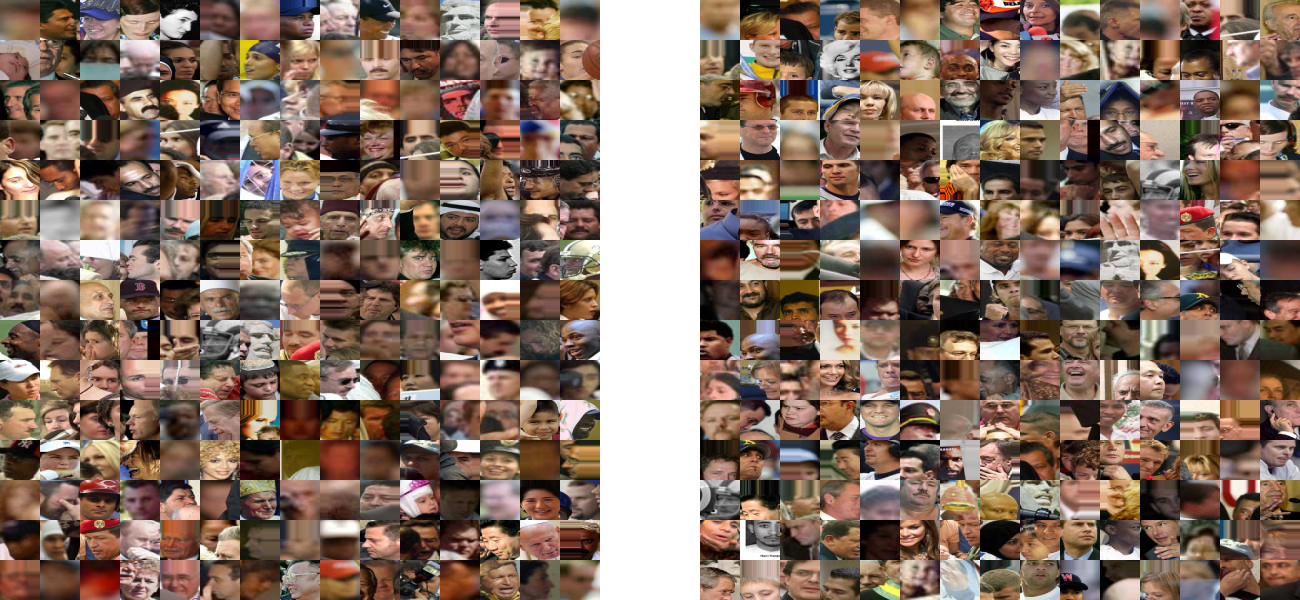

In [54]:
w,h = 40, 40
show_num = 225
canvas = toyplot.Canvas(width=1300, height=600, autorender=True, autoformat='png')
offset = 700
sv_plot = np.random.permutation(SV_pos)[:show_num]
for i in range(show_num):
    x = i%15
    y = i//15
    mark = canvas.image(db[sv_plot[i]][0], bounds=(x*w,(x+1)*w,y*h,(y+1)*h))
sv_plot = np.random.permutation(SV_neg)[:show_num]
for i in range(show_num):
    x = i%15
    y = i//15
    mark = canvas.image(db[sv_plot[i]][0], bounds=(offset+x*w,offset+(x+1)*w,y*h,(y+1)*h))
canvas.image

### Linear

In [24]:
M = Model.SVM({'kernel':'linear','verbose':True})
M.fit(X_train,y_train)
print("Training accuracy: {}".format(M.get_acc(X_train,y_train)))

[LibSVM]Training accuracy: 0.9807543520309477


In [69]:
print("Validating accuracy: {}".format(M.get_acc(X_val,y_val)))

Validating accuracy: 0.9757832019988468


#### Save Model

In [26]:
with open('./Model_checkpoints/SVM_linear.pkl','wb') as fh:
    dill.dump(M, fh)

#### Load Pretrained Model

In [55]:
with open('./Model_checkpoints/SVM_linear.pkl','rb') as fh:
    M = dill.load(fh)

In [56]:
SVs = M.get_SV()
SVs.sort()
SV_pos = SVs[(SVs<4136).nonzero()[0]]
SV_neg = SVs[(SVs>=4136).nonzero()[0]]
print(SV_pos.shape, SV_neg.shape, SVs.shape)

(681,) (802,) (1483,)


In [ ]:
import toyplot
db = FDDB('train_list.npy',crop=True, transform= T.Resize((96,96)))
image = db[0][0]

<bound method Canvas.image of <toyplot.canvas.Canvas object at 0x7fd084246198>>

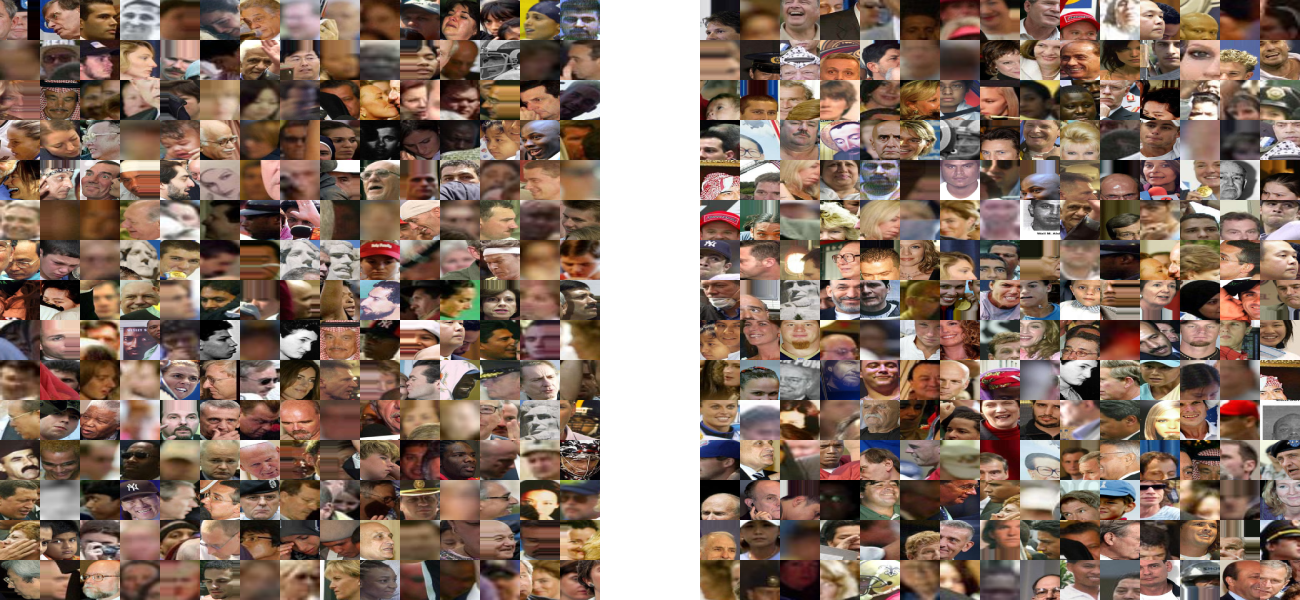

In [57]:
w,h = 40, 40
show_num = 225
canvas = toyplot.Canvas(width=1300, height=600, autorender=True, autoformat='png')
offset = 700
sv_plot = np.random.permutation(SV_pos)[:show_num]
for i in range(show_num):
    x = i%15
    y = i//15
    mark = canvas.image(db[sv_plot[i]][0], bounds=(x*w,(x+1)*w,y*h,(y+1)*h))
sv_plot = np.random.permutation(SV_neg)[:show_num]
for i in range(show_num):
    x = i%15
    y = i//15
    mark = canvas.image(db[sv_plot[i]][0], bounds=(offset+x*w,offset+(x+1)*w,y*h,(y+1)*h))
canvas.image

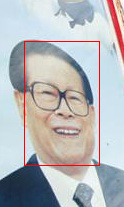

In [61]:
db.draw_bndbox(18109,8)

## Convolutional Neural Network

To take the advantage of feature selecting ability in Neural Network, I directly use resized raw image for training

In [2]:
M = Model.CNN({
    'arch': 'resnet18',
    'epochs': 90,
    'optim': 'SGD',
    'save': True
})
db_train = FDDB('train_list.npy', 
                transform=T.Compose([
                    T.RandomHorizontalFlip(),
                    M.img_trans
                ]),
                zero_one=True
               )
db_val = FDDB('val_list.npy', 
              transform=M.img_trans,
              zero_one=True
             )
M.set_dataset(db_train, db_val)

In [2]:
M.fit()

Train Acc 1.0000 Test Acc 0.9919 (0.9914): 100%|██████████| 90/90 [33:41<00:00, 22.18s/it]


In [5]:
M.load_checkpoint('checkpoint_resnet18_.pth.tar')

=> loading checkpoint 'checkpoint_resnet18_.pth.tar'
=> loaded checkpoint 'checkpoint_resnet18_.pth.tar' (epoch 90) as Teacher!


In [6]:
M.validate()

(0.0487492853735458, tensor(0.9875, device='cuda:0'))

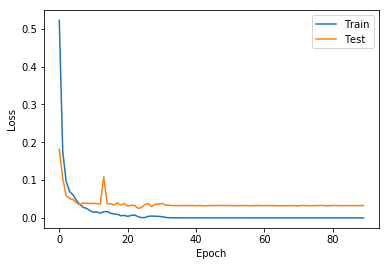

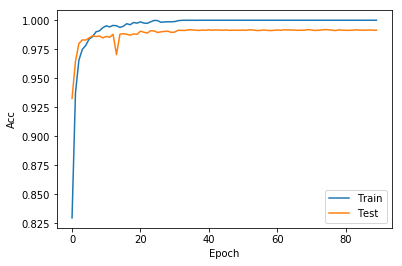

In [5]:
plt.figure()
plt.plot(M.logger['train_loss'])
plt.plot(M.logger['test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.show()
plt.figure()
plt.plot(M.logger['train_acc'])
plt.plot(M.logger['test_acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['Train','Test'])
plt.show()
